In [52]:

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import ParameterGrid
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
import cv2
import os
import glob



In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [54]:
torch.cuda.empty_cache()

In [55]:
# Define paths
train_path = r"C:\Users\Ariq Dreiki Hajjanto\Documents\Tugas Akhir\Dataset\Dataset\75_25\Training"
test_path = r"C:\Users\Ariq Dreiki Hajjanto\Documents\Tugas Akhir\Dataset\Dataset\75_25\Testing"


In [56]:
# Define data transforms
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [57]:
# Load the VGG16 model pre-trained on ImageNet dataset
vgg_model = models.vgg16(pretrained=True).to(device)
vgg_model.classifier[-1] = nn.Identity()  # Remove the last classification layer


c:\Users\Ariq Dreiki Hajjanto\anaconda3\envs\TA\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ariq Dreiki Hajjanto\anaconda3\envs\TA\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [58]:
summary(vgg_model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [59]:
def extract_features_from_directory(directory, model):
    features = []
    labels_list = []
    dataset = datasets.ImageFolder(directory, transform=data_transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)  # Move inputs to the appropriate device
            outputs = model(inputs)
            outputs = outputs.cpu().numpy().flatten()  # Move outputs to CPU and convert to numpy array
            features.append(outputs)
            labels_list.append(labels.item())
    return np.array(features), np.array(labels_list)
# Define a function to save extracted features as CSV
def save_features_to_csv(features, labels, file_path):
    data = np.concatenate((features, labels[:, np.newaxis]), axis=1)
    np.savetxt(file_path, data, delimiter=",", header=",".join([f"feature_{i}" for i in range(features.shape[1])]) + ",label", comments="")

In [60]:
# Extract features and labels from training and testing directories
X_train, y_train = extract_features_from_directory(train_path, vgg_model)
X_test, y_test = extract_features_from_directory(test_path, vgg_model)

In [61]:
# Reduce the dimensionality of the features to 1000 using PCA
pca = PCA(n_components=1000)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [62]:
# # Save extracted features as CSV
# save_features_to_csv(X_train_pca, y_train, "X_train_features75_25.csv")
# save_features_to_csv(X_test_pca, y_test, "X_test_features75_25.csv")

In [63]:
print("X_train_pca features shape:", X_train_pca.shape)
print("y_train features shape:", y_train.shape)
print("X_test_pca features shape:", X_test_pca.shape)
print("y_test features shape:", y_test.shape)


X_train_pca features shape: (3765, 1000)
y_train features shape: (3765,)
X_test_pca features shape: (1258, 1000)
y_test features shape: (1258,)


In [64]:
print ('array',X_train_pca)

array [[ 9.04047585e+00 -3.21765232e+00  9.61292362e+00 ... -1.91647634e-01
   7.58690611e-02  8.29374325e-03]
 [ 1.60323753e+01 -6.67275286e+00 -4.22920799e+00 ... -5.25936559e-02
  -4.30151708e-02  2.97076181e-02]
 [ 4.21117640e+00 -1.84098387e+00  1.06557779e+01 ... -3.32140476e-01
  -8.33322704e-02 -1.54916169e-02]
 ...
 [-6.72255945e+00  4.92299891e+00 -5.48987865e+00 ... -2.57379413e-01
  -9.52121839e-02 -1.66124031e-02]
 [-1.21062174e+01  6.88157499e-01 -4.56059551e+00 ... -2.45042052e-02
   1.10657826e-01 -9.55103636e-02]
 [ 5.64245129e+00  9.57639885e+00  2.45332360e+00 ... -4.87361886e-02
  -9.96935815e-02  9.10736248e-02]]


In [65]:
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_test:", np.unique(y_test))


Unique labels in y_train: [0 1 2]
Unique labels in y_test: [0 1 2]


In [66]:
# Create dataframes for training and testing labels
df_train_labels = pd.DataFrame({'label': y_train})
df_test_labels = pd.DataFrame({'label': y_test})

# Save dataframes to CSV files
df_train_labels.to_csv('train_labels.csv', index=False)
df_test_labels.to_csv('test_labels.csv', index=False)

In [67]:
df = pd.read_csv(r"C:\Users\Ariq Dreiki Hajjanto\Documents\Tugas Akhir\Dataset\Machine Learning\CNN\X_train_features75_25.csv")
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_991,feature_992,feature_993,feature_994,feature_995,feature_996,feature_997,feature_998,feature_999,label
0,9.040694,-3.217679,9.613105,9.460271,-4.335622,-6.121917,-5.611620,-8.326259,4.640048,-3.671542,...,-0.174629,0.315323,0.061428,-0.078918,0.104021,0.056637,0.025103,0.027028,0.183406,0.0
1,16.032400,-6.672801,-4.229318,-3.846205,-8.777212,-5.445901,0.959049,2.908781,1.835645,-0.991601,...,0.030725,-0.080713,0.051528,-0.053457,0.075920,-0.180227,0.047563,-0.090536,0.060283,0.0
2,4.211185,-1.840962,10.655706,3.726179,4.965624,-0.994953,-2.638854,-6.066085,5.139488,-3.246870,...,0.027740,-0.169251,0.128171,0.128390,-0.040275,-0.322302,0.002928,-0.028275,0.038589,0.0
3,5.836779,3.002416,0.125132,5.158146,-5.567802,-6.197261,-3.349917,1.223286,1.647525,2.286715,...,-0.347347,0.105386,0.020078,-0.121952,-0.141058,0.220783,-0.157603,0.023027,-0.000375,0.0
4,15.055794,-0.820486,-3.930887,-8.075213,-0.319468,3.377699,-4.551379,3.558262,-4.642244,-0.702654,...,-0.089912,-0.287378,0.063338,0.273116,0.205913,0.016083,-0.172260,0.037439,-0.085371,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3760,-10.292949,3.327847,-3.845964,0.480565,2.361598,6.838064,4.540898,-4.218620,6.427249,-0.272012,...,0.110758,-0.013993,0.123943,-0.217827,0.019962,-0.053700,-0.149923,0.028321,0.026027,2.0
3761,-8.811209,7.598347,-3.063248,3.735364,6.685120,8.289068,5.489656,-2.356707,3.140974,3.011789,...,-0.034724,-0.046531,0.230146,-0.083493,0.221696,-0.126501,0.112229,0.038581,-0.097541,2.0
3762,-6.722556,4.923002,-5.489904,3.557411,4.100451,8.708639,7.097209,1.585063,6.864124,4.597272,...,0.131718,-0.130360,0.132595,0.089872,-0.078631,-0.022569,0.010281,-0.226249,0.047090,2.0
3763,-12.106224,0.688160,-4.560599,1.496846,3.862783,0.015975,2.563817,-0.565341,3.157855,0.686453,...,0.031482,0.009815,0.098677,0.163524,0.177405,-0.101621,-0.256378,-0.026993,0.029636,2.0


In [68]:
df.isnull().sum()

feature_0      0
feature_1      0
feature_2      0
feature_3      0
feature_4      0
              ..
feature_996    0
feature_997    0
feature_998    0
feature_999    0
label          0
Length: 1001, dtype: int64

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3765 entries, 0 to 3764
Columns: 1001 entries, feature_0 to label
dtypes: float64(1001)
memory usage: 28.8 MB


In [70]:
df.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_991,feature_992,feature_993,feature_994,feature_995,feature_996,feature_997,feature_998,feature_999,label
count,3765.000000,3.765000e+03,3.765000e+03,3765.000000,3.765000e+03,3765.000000,3765.000000,3.765000e+03,3.765000e+03,3.765000e+03,...,3.765000e+03,3.765000e+03,3.765000e+03,3.765000e+03,3.765000e+03,3.765000e+03,3.765000e+03,3.765000e+03,3.765000e+03,3765.000000
mean,-0.000001,2.820848e-07,-5.799814e-07,-0.000002,-6.580539e-07,-0.000001,0.000002,-3.084878e-07,3.116429e-07,-1.047330e-08,...,3.703125e-07,-4.342997e-07,1.220212e-07,-5.757448e-07,1.727257e-07,2.918644e-07,-1.461576e-07,2.152212e-07,2.415870e-07,1.027092
std,8.754831,6.178053e+00,5.836872e+00,5.247678,4.380038e+00,3.850439,3.651153,3.481011e+00,3.071140e+00,2.931748e+00,...,1.322211e-01,1.321875e-01,1.318031e-01,1.316522e-01,1.311398e-01,1.310657e-01,1.308936e-01,1.307227e-01,1.303581e-01,0.819728
min,-14.562901,-1.734569e+01,-1.548392e+01,-15.995855,-1.430037e+01,-11.076268,-12.712283,-1.144840e+01,-1.223887e+01,-1.110475e+01,...,-4.841211e-01,-4.349316e-01,-4.666416e-01,-4.532725e-01,-4.167269e-01,-4.899539e-01,-5.333118e-01,-4.336307e-01,-4.562045e-01,0.000000
25%,-7.380589,-4.330677e+00,-4.224631e+00,-3.751481,-3.065017e+00,-2.571187,-2.480946,-2.343667e+00,-2.100724e+00,-1.912835e+00,...,-8.736268e-02,-8.674422e-02,-8.384877e-02,-8.739940e-02,-8.971452e-02,-8.473880e-02,-8.557136e-02,-8.763272e-02,-8.250637e-02,0.000000
50%,-2.974455,-6.630430e-01,-1.431538e-01,0.110530,2.883876e-02,0.075174,-0.001138,-3.658550e-02,-5.866443e-02,-8.319752e-02,...,2.458408e-03,1.868638e-03,-9.789368e-04,1.397280e-03,6.859222e-04,6.106581e-04,-3.008729e-03,-4.410712e-04,8.612490e-04,1.000000
75%,8.076040,4.077885e+00,4.620282e+00,3.576378,2.953142e+00,2.608989,2.556958,2.347683e+00,2.009837e+00,1.861705e+00,...,8.740839e-02,8.349839e-02,8.236695e-02,8.758102e-02,8.587383e-02,8.913472e-02,8.657827e-02,8.685534e-02,8.653830e-02,2.000000
max,21.634211,1.818072e+01,1.651432e+01,17.171587,1.495592e+01,14.445322,13.305742,1.251303e+01,1.266064e+01,1.218140e+01,...,5.503996e-01,5.479062e-01,4.811938e-01,4.984233e-01,4.306073e-01,5.796111e-01,5.337352e-01,4.894527e-01,4.893871e-01,2.000000


In [71]:
df.nunique()

feature_0      3725
feature_1      3742
feature_2      3742
feature_3      3732
feature_4      3732
               ... 
feature_996    3756
feature_997    3755
feature_998    3757
feature_999    3755
label             3
Length: 1001, dtype: int64

***HYPERPARAMETER TUNING***

In [72]:
# Define the parameters grid for each kernel
param_grids = {
    'rbf': {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]},
    'sigmoid': {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1], 'coef0': [0.0, 0.5, 1.0]},
    'poly': {'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4], 'coef0': [0.0, 0.5, 1.0]}
}

In [73]:
# Initialize best parameters and best accuracy for each kernel
best_params = {}
best_accuracy = {}

In [74]:
# Loop through each kernel
for kernel, param_grid in param_grids.items():
    # Initialize best accuracy for current kernel
    best_accuracy[kernel] = 0
    
    # Loop through each parameter combination for current kernel
    for params in ParameterGrid(param_grid):
        # Initialize SVM classifier with current parameters
        svm_classifier = SVC(kernel=kernel, **params)
        
        # Train SVM classifier on training data
        svm_classifier.fit(X_train_pca, y_train)
        
        # Make predictions on test data
        y_pred = svm_classifier.predict(X_test_pca)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Print accuracy for the current parameter combination
        print(f"Kernel: {kernel}, Parameters: {params}, Accuracy: {accuracy}")
        
        # Check if current accuracy is better than previous best accuracy for current kernel
        if accuracy > best_accuracy[kernel]:
            # Update best accuracy and parameters for current kernel
            best_accuracy[kernel] = accuracy
            best_params[kernel] = params

Kernel: rbf, Parameters: {'C': 0.1, 'gamma': 0.001}, Accuracy: 0.8505564387917329
Kernel: rbf, Parameters: {'C': 0.1, 'gamma': 0.01}, Accuracy: 0.3799682034976153
Kernel: rbf, Parameters: {'C': 0.1, 'gamma': 0.1}, Accuracy: 0.3497615262321145
Kernel: rbf, Parameters: {'C': 0.1, 'gamma': 1}, Accuracy: 0.3497615262321145
Kernel: rbf, Parameters: {'C': 1, 'gamma': 0.001}, Accuracy: 0.910174880763116
Kernel: rbf, Parameters: {'C': 1, 'gamma': 0.01}, Accuracy: 0.9300476947535771
Kernel: rbf, Parameters: {'C': 1, 'gamma': 0.1}, Accuracy: 0.3863275039745628
Kernel: rbf, Parameters: {'C': 1, 'gamma': 1}, Accuracy: 0.38553259141494434
Kernel: rbf, Parameters: {'C': 10, 'gamma': 0.001}, Accuracy: 0.9538950715421304
Kernel: rbf, Parameters: {'C': 10, 'gamma': 0.01}, Accuracy: 0.9348171701112877
Kernel: rbf, Parameters: {'C': 10, 'gamma': 0.1}, Accuracy: 0.3863275039745628
Kernel: rbf, Parameters: {'C': 10, 'gamma': 1}, Accuracy: 0.38553259141494434
Kernel: rbf, Parameters: {'C': 100, 'gamma': 0.0

In [75]:
print("Best parameters for each kernel:")
for kernel, params in best_params.items():
    print(f"{kernel}: {params} - Accuracy: ", end="")
    if best_accuracy[kernel] == max(best_accuracy.values()):
        print(f"\033[1m{best_accuracy[kernel]}\033[0m (Best)")
    else:
        print(best_accuracy[kernel])

Best parameters for each kernel:
rbf: {'C': 100, 'gamma': 0.001} - Accuracy: 0.9546899841017488
sigmoid: {'C': 1, 'coef0': 0.0, 'gamma': 0.001} - Accuracy: 0.8799682034976153
poly: {'C': 10, 'coef0': 0.5, 'degree': 3} - Accuracy: 0.9570747217806042 (Best)


***SVM CLASSIFIER***

In [76]:
# Train the SVM classifier with the best hyperparameters
best_svm_classifier = SVC(kernel='poly',C= 10.0, coef0= 0.5, degree= 3)#poly: {'C': 1, 'coef0': 1.0, 'degree': 4}
best_svm_classifier.fit(X_train_pca, y_train)

SVC(C=10.0, coef0=0.5, kernel='poly')

In [77]:
# Make predictions on the test set
y_pred = best_svm_classifier.predict(X_test_pca)

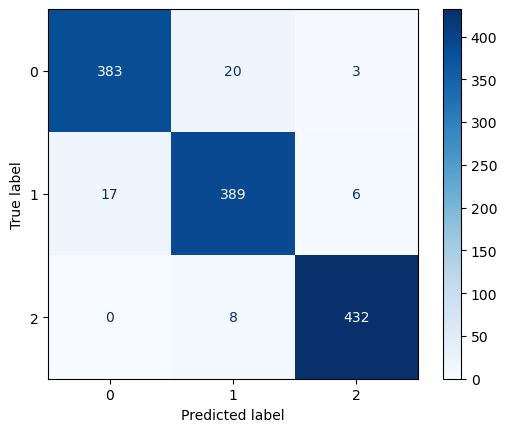

In [78]:
cm = confusion_matrix(y_test, y_pred, labels=best_svm_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_svm_classifier.classes_)
disp.plot(cmap='Blues')
plt.show()

In [79]:
# Define a dictionary to map numerical labels to class labels
numerical_to_class = {0: 'glioma', 1: 'meningioma', 2: 'pituitary'}

# Convert numerical labels in y_test and y_pred to class labels
y_test_class = np.array([numerical_to_class[label] for label in y_test])
y_pred_class = np.array([numerical_to_class[label] for label in y_pred])

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test_class, y_pred_class))
print("Accuracy:", accuracy_score(y_test_class, y_pred_class))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.94      0.95       406
  meningioma       0.93      0.94      0.94       412
   pituitary       0.98      0.98      0.98       440

    accuracy                           0.96      1258
   macro avg       0.96      0.96      0.96      1258
weighted avg       0.96      0.96      0.96      1258

Accuracy: 0.9570747217806042


In [80]:
# Define image size
SIZE = 224
train_images = []
train_labels = []

test_images = []
test_labels = []

In [81]:
for directory_path in glob.glob(os.path.join(train_path, "*")):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        train_images.append(img)  # Append image array
        train_labels.append(label)

for directory_path in glob.glob(os.path.join(test_path, "*")):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        test_images.append(img)  # Append image array
        test_labels.append(label)

In [82]:
label_encoder = LabelEncoder()
# Fit label encoder and return encoded labels
y_train_encoded = label_encoder.fit_transform(train_labels)
y_test_encoded = label_encoder.transform(test_labels)

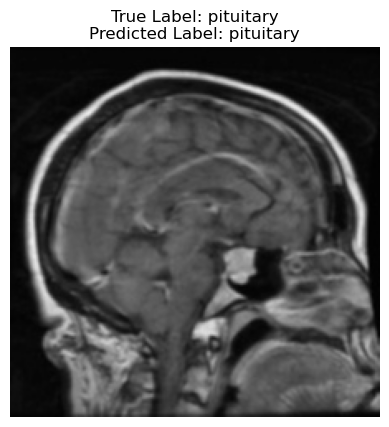

In [107]:

# Choose a random index for selecting an image
random_index = np.random.choice(len(test_images))

# Display the selected image with true and predicted labels
image = test_images[random_index]
true_label = test_labels[random_index]
predicted_label = label_encoder.inverse_transform([y_pred[random_index]])[0]

plt.imshow(image)
plt.axis('off')
plt.title(f'True Label: {true_label}\nPredicted Label: {predicted_label}')
plt.show()

In [84]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
best_svm_classifier.fit(X_train_pca, y_train)

x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = best_svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

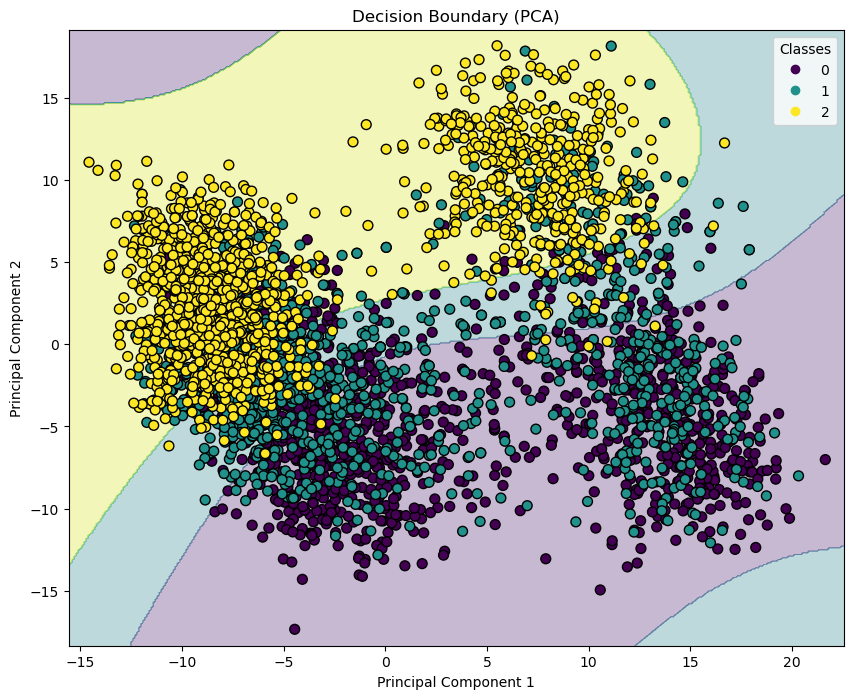

In [85]:
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
scatter= plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', s=50, edgecolors='k')
handles, labels = scatter.legend_elements()
plt.legend(handles, labels, loc="upper right", title="Classes")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary (PCA)')
plt.show()

In [86]:
# Plot decision boundary using test data
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = best_svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

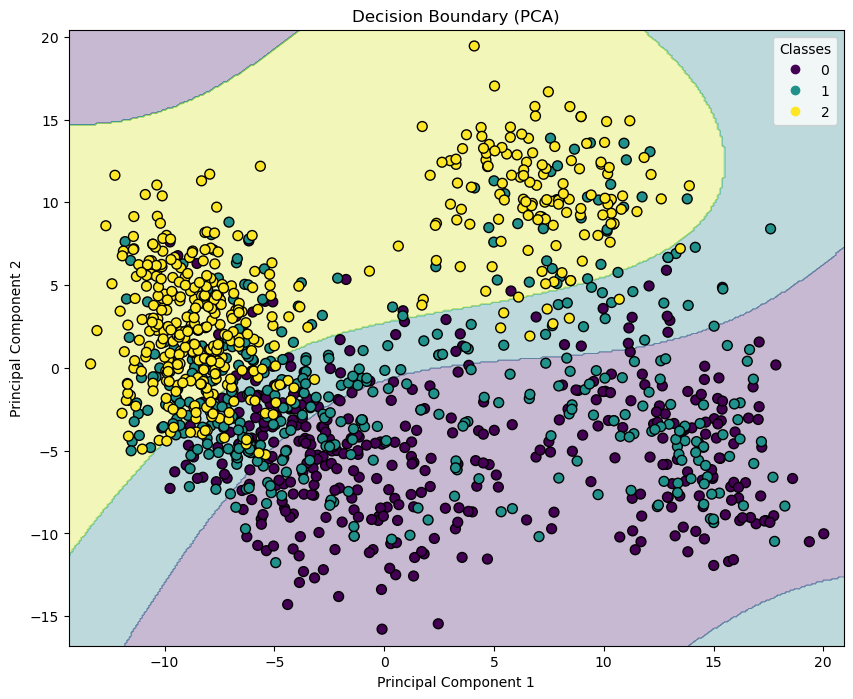

In [87]:
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
scatter1= plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', s=50, edgecolors='k')
# Add legend
handles1, labels1 = scatter1.legend_elements()
plt.legend(handles1, labels1, loc="upper right", title="Classes")

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary (PCA)')
plt.show()

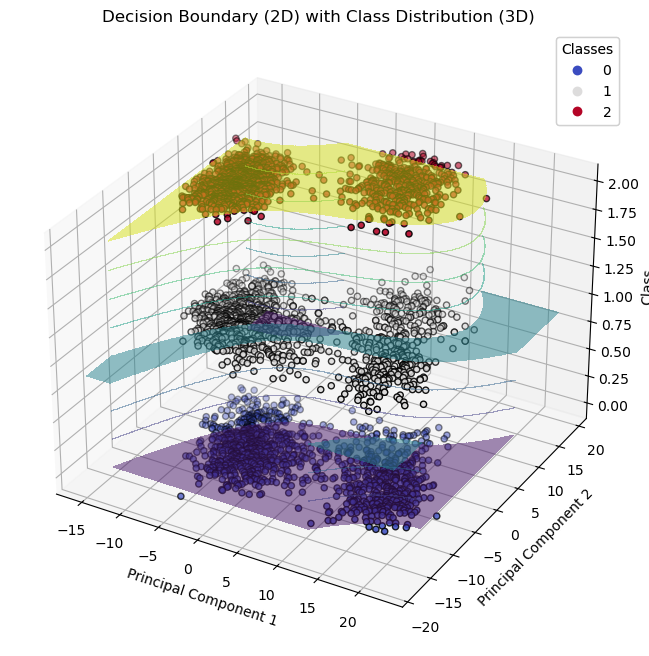

In [88]:
# Plot the decision boundary in 2D with class distribution in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot decision boundary
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = best_svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=0.5)
# Plot class distribution in 3D
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Class')
ax.set_title('Decision Boundary (2D) with Class Distribution (3D)')

# Add legend for class distribution
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

plt.show()

In [89]:
# # Perform the nonlinear transformation
# X_train_transformed = np.zeros((X_train_pca.shape[0], 3))
# X_train_transformed[:, 0] = X_train_pca[:, 0] ** 2
# X_train_transformed[:, 1] = X_train_pca[:, 1] - np.sqrt(X_train_pca[:, 0] * X_train_pca[:, 1])
# X_train_transformed[:, 2] = X_train_pca[:, 1] ** 2

In [90]:
# # Check for NaN values in the transformed features
# nan_indices = np.isnan(X_train_transformed).any(axis=1)

# # Replace NaN values with the mean of the column
# X_train_transformed[nan_indices] = np.nanmean(X_train_transformed, axis=0)

# # Train the SVM classifier on the transformed data
# best_svm_classifier.fit(X_train_transformed, y_train)

In [91]:
# # Define the range of the meshgrid in the transformed space
# x_min, x_max = X_train_transformed[:, 0].min() - 1, X_train_transformed[:, 0].max() + 1
# y_min, y_max = X_train_transformed[:, 1].min() - 1, X_train_transformed[:, 1].max() + 1
# z_min, z_max = X_train_transformed[:, 2].min() - 1, X_train_transformed[:, 2].max() + 1

# # Define the step size for each dimension
# step_size = 0.5

# # Create a meshgrid in the transformed space with the specified step size
# xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, step_size),
#                          np.arange(y_min, y_max, step_size),
#                          np.arange(z_min, z_max, step_size))

# # Predict the class labels for each point on the meshgrid
# meshgrid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
# Z = best_svm_classifier.predict(meshgrid_points)
# Z = Z.reshape(xx.shape)

In [92]:
# # Plot decision boundary and class distribution in 3D
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_train_transformed[:, 0], X_train_transformed[:, 1], X_train_transformed[:, 2], c=y_train, cmap='viridis', s=50, edgecolors='k')
# Z_2d = Z[:,:,0]

# # Plot the decision boundary
# ax.contourf(xx[:,:,0], yy[:,:,0], Z_2d, alpha=0.3, cmap='viridis')

# # Set labels and title
# ax.set_xlabel('Transformed Feature 1')
# ax.set_ylabel('Transformed Feature 2')
# ax.set_zlabel('Transformed Feature 3')
# ax.set_title('Decision Boundary in Transformed 3D Space')

# # Add legend for class distribution
# handles, labels = scatter.legend_elements()
# ax.legend(handles, labels, loc="upper right", title="Classes")

# plt.show()